In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check the folder
!ls

drive  sample_data


**Import Libraries**

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

import time

In [ ]:
# Keras & Tensorflow
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

**Load the Dataset as Numpy array file**

In [ ]:
benign_train = np.load('/content/drive/MyDrive/CSE499/numpy/benign_train.npy')
malign_train = np.load('/content/drive/MyDrive/CSE499/numpy/malign_train.npy')
benign_test = np.load('/content/drive/MyDrive/CSE499/numpy/benign_test.npy')
malign_test = np.load('/content/drive/MyDrive/CSE499/numpy/malign_test.npy')
print('Done Loaded :)')

Done Loaded :)


In [ ]:
#Shape of our dataset
print(f'Benign Train:',benign_train.shape)
print(f'Malignant Train',malign_train.shape)
print(f'Benign Test:',benign_test.shape)
print(f'Malignant Test',malign_test.shape)

Benign Train: (3500, 224, 224, 3)
Malignant Train (3496, 224, 224, 3)
Benign Test: (1500, 224, 224, 3)
Malignant Test (1500, 224, 224, 3)


**Visualization**

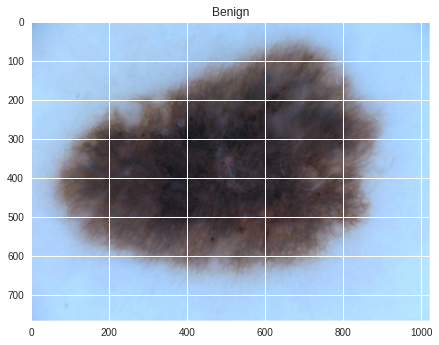

In [ ]:
im = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/benign/ISIC_0000000.jpeg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title('Benign')
plt.show()

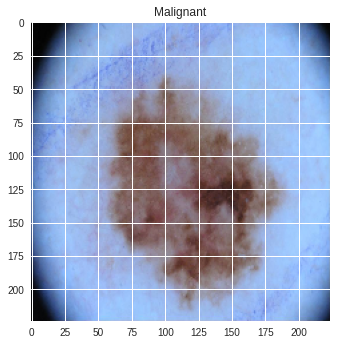

In [ ]:
im = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/malignant/ISIC_0000002.jpeg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.title('Malignant')
plt.show()

**Create Label for each class 0.0 = Benign , 1.0 = malignant**

In [ ]:
benign_train_label = np.zeros(len(benign_train),dtype=float)
malign_train_label = np.ones(len(malign_train),dtype=float)
benign_test_label = np.zeros(len(benign_test),dtype=float)
malign_test_label = np.ones(len(malign_test),dtype=float) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
print(f'X train shape:',X_train.shape)
print(f'X test shape:',X_test.shape)
print(f'Y train shape:',Y_train.shape)
print(f'Y test shape:',Y_test.shape)

X train shape: (6996, 224, 224, 3)
X test shape: (3000, 224, 224, 3)
Y train shape: (6996, 2)
Y test shape: (3000, 2)


Split the Train and Valid

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

In [ ]:
print(f'x train shape:',x_train.shape)
print(f'x val shape:',x_val.shape)
print(f'y train shape:',y_train.shape)
print(f'y val shape:',y_val.shape)

x train shape: (5596, 224, 224, 3)
x val shape: (1400, 224, 224, 3)
y train shape: (5596, 2)
y val shape: (1400, 2)


Let's display Some images

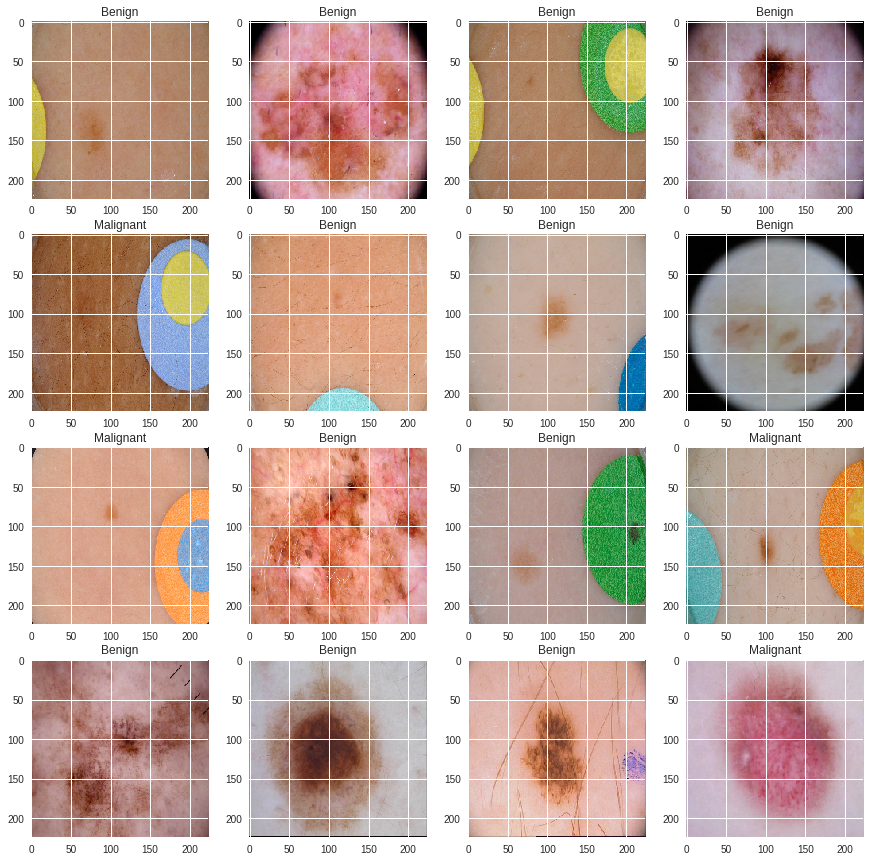

In [ ]:
w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows +1): 
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

**ResNet50 as a Teacher model**

In [ ]:
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2 , activation='softmax'))
  
  model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return model

resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224 , 224 , 3)
)
#call the model 
model = build_model(resnet , lr = 1e-4)
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1 (ModuleWrap (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


**Training the teacher model with Resnet50**

In [ ]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
epochs = 10
batch_size = 64
teacher_his = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/10
88/88 [==============================] - 65s 680ms/step - loss: 0.2589 - accuracy: 0.8989 - val_loss: 0.1916 - val_accuracy: 0.9193
Epoch 2/10
88/88 [==============================] - 59s 674ms/step - loss: 0.0623 - accuracy: 0.9775 - val_loss: 0.0994 - val_accuracy: 0.9600
Epoch 3/10
88/88 [==============================] - 59s 666ms/step - loss: 0.0266 - accuracy: 0.9924 - val_loss: 0.1246 - val_accuracy: 0.9536
Epoch 4/10
88/88 [==============================] - 59s 670ms/step - loss: 0.0223 - accuracy: 0.9914 - val_loss: 0.1864 - val_accuracy: 0.9350
Epoch 5/10
88/88 [==============================] - 59s 671ms/step - loss: 0.0141 - accuracy: 0.9956 - val_loss: 0.1880 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 59s 673ms/step - loss: 0.0167 - accuracy: 0.9930 - val_loss: 0.1055 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 59s 674ms/step - loss: 0.0185 - accuracy: 0.9923 - val_loss: 0.1356 - val_accuracy: 0.9721

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [ ]:
Y_val_pred = model.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The Teacher model Accuracy on the Validation Set: 0.9721428571428572


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[6.1347412e-09 1.0000000e+00]
 [1.1617897e-05 9.9998844e-01]
 [7.0442780e-05 9.9992955e-01]
 ...
 [3.6851503e-03 9.9631482e-01]
 [9.9999213e-01 7.8534931e-06]
 [4.3529494e-07 9.9999952e-01]]

Time:  10.259813463999762 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Teacher model with ResNet50 on the Test set is: 0.9963333333333333


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1500
           1       1.00      0.99      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



**AUC-ROC Curve**

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)

0.9963333333333333


In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)


# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

-------

**Student Models**

**MobileNet**

In [ ]:
from tensorflow.keras.applications import MobileNet

def mobile_model1(backbone , lr = 1e-4):
  model1 = Sequential()
  model1.add(backbone)
  model1.add(layers.GlobalAveragePooling2D())
  model1.add(layers.Dropout(0.5))
  model1.add(layers.BatchNormalization())
  model1.add(layers.Dense(2 , activation='softmax'))
  
  model1.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return model1


mobilenet1 = MobileNet(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model 
model1 = mobile_model1(mobilenet1 , lr = 1e-4)
model1.build((None, 224, 224, 3))
model1.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 3,235,010
Trainable params: 3,211,074
Non-trainable params: 23,936
_________________________________________________________________


**Temperature = 10**

In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets
#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense_1').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

[[0.3103464  0.68965364]]




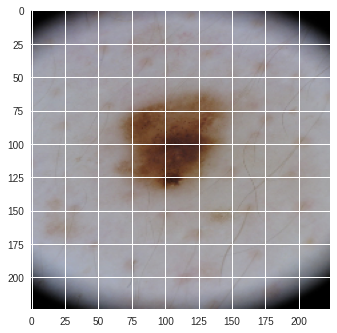

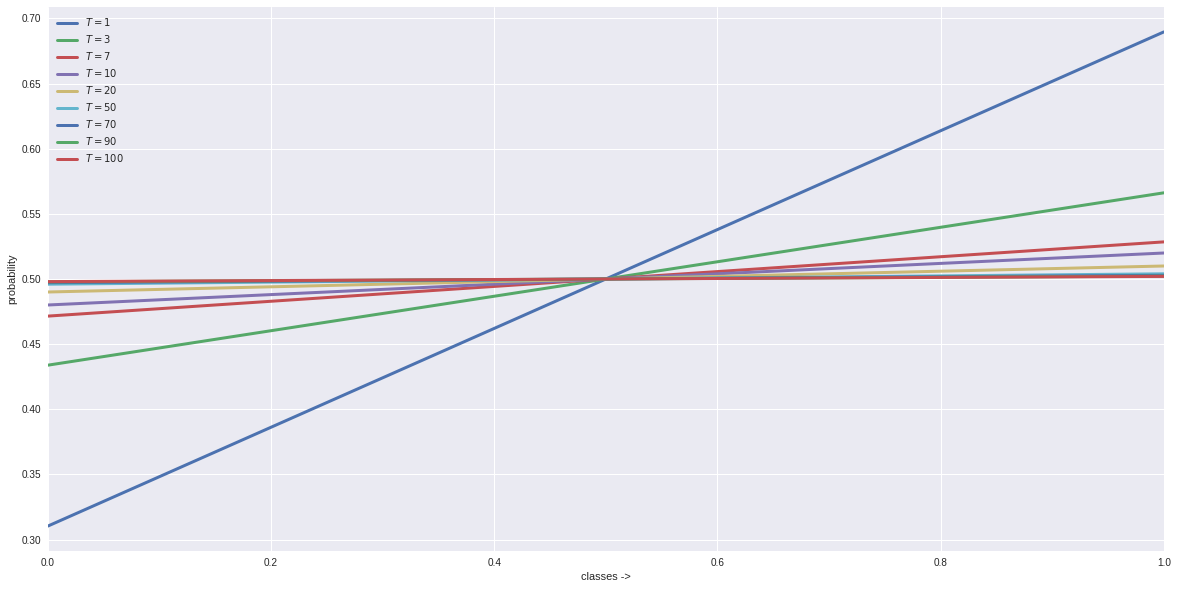

In [ ]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(x_train[122].reshape(1,224,224,3))
print(softmax(intermediate_output))
print('\n')

pixels = x_train[122]
pixels = pixels.reshape((224, 224, 3))
plt.imshow(pixels)
plt.show()
print('\n')

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize = (20, 10));

temperature = [1,3,7,10,20,50,70,90,100]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=3);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 1]);
plt.show()


In [ ]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
model1.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = model1.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model as mobileNet
model1 = Model(model1.input, output)

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
module_wrapper_2_input (InputLa [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
module_wrapper_2 (ModuleWrapper (None, 7, 7, 1024)   3228864     module_wrapper_2_input[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 1024)         0           module_wrapper_2[0][0]           
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 1024)         0           global_average_pooling2d_2[0][0] 
____________________________________________________________________________________________

**Distill Loss Function**

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function
nb_classes = 2
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

model1.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] 
  )

In [ ]:
# Train the student model with MobileNet
epochs = 20
batch_size = 64
student_his = model1.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 38s 387ms/step - loss: 0.0687 - acc: 0.5689 - val_loss: 0.0632 - val_acc: 0.6650
Epoch 2/20
88/88 [==============================] - 33s 376ms/step - loss: 0.0662 - acc: 0.6087 - val_loss: 0.0594 - val_acc: 0.7471
Epoch 3/20
88/88 [==============================] - 32s 368ms/step - loss: 0.0639 - acc: 0.6413 - val_loss: 0.0567 - val_acc: 0.7800
Epoch 4/20
88/88 [==============================] - 32s 367ms/step - loss: 0.0609 - acc: 0.6779 - val_loss: 0.0546 - val_acc: 0.8164
Epoch 5/20
88/88 [==============================] - 33s 370ms/step - loss: 0.0597 - acc: 0.6927 - val_loss: 0.0526 - val_acc: 0.8364
Epoch 6/20
88/88 [==============================] - 33s 373ms/step - loss: 0.0576 - acc: 0.7236 - val_loss: 0.0509 - val_acc: 0.8521
Epoch 7/20
88/88 [==============================] - 33s 372ms/step - loss: 0.0563 - acc: 0.7535 - val_loss: 0.0494 - val_acc: 0.8700
Epoch 8/20
88/88 [==============================] - 32s 369ms/step - 

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(student_his.history['acc'])
plt.plot(student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(student_his.history['loss'])
plt.plot(student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [ ]:
Y_val_pred = model.predict(x_val)
print(f'The MobileNet model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The MobileNet model Accuracy on the Validation Set: 0.9721428571428572


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model1.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.3499705  0.6500295  0.48452574 0.5154743 ]
 [0.28067783 0.71932214 0.4764898  0.5235102 ]
 [0.31557587 0.68442416 0.48065522 0.5193448 ]
 ...
 [0.28083512 0.71916485 0.47650924 0.5234907 ]
 [0.7074455  0.29255447 0.52206093 0.47793907]
 [0.2749452  0.72505474 0.4757771  0.5242229 ]]

Time:  5.141652872000122 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Student model with MobileNet on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Student model with MobileNet on the Test set is: 0.9853333333333333


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1500
           1       0.99      0.98      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)


# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

----

**VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16

def vgg16_model(backbone , lr = 1e-4):
  modelvgg16 = Sequential()
  modelvgg16.add(backbone)
  modelvgg16.add(layers.GlobalAveragePooling2D())
  modelvgg16.add(layers.Dropout(0.5))
  modelvgg16.add(layers.BatchNormalization())
  modelvgg16.add(layers.Dense(2 , activation='softmax'))
  
  modelvgg16.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return modelvgg16


vgg16 = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
# call the model 
modelvgg16 = vgg16_model(vgg16 , lr = 1e-4)
modelvgg16.build((None, 224, 224, 3))
modelvgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 14,717,762
Trainable params: 14,716,738
Non-trainable params: 1,024
_________________________________________________________________


In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense_1').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

[[0.3103464  0.68965364]]




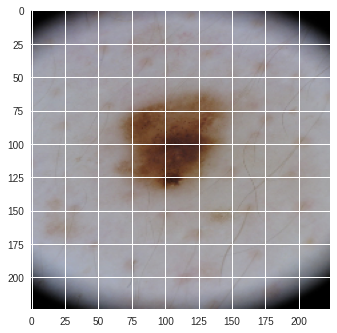

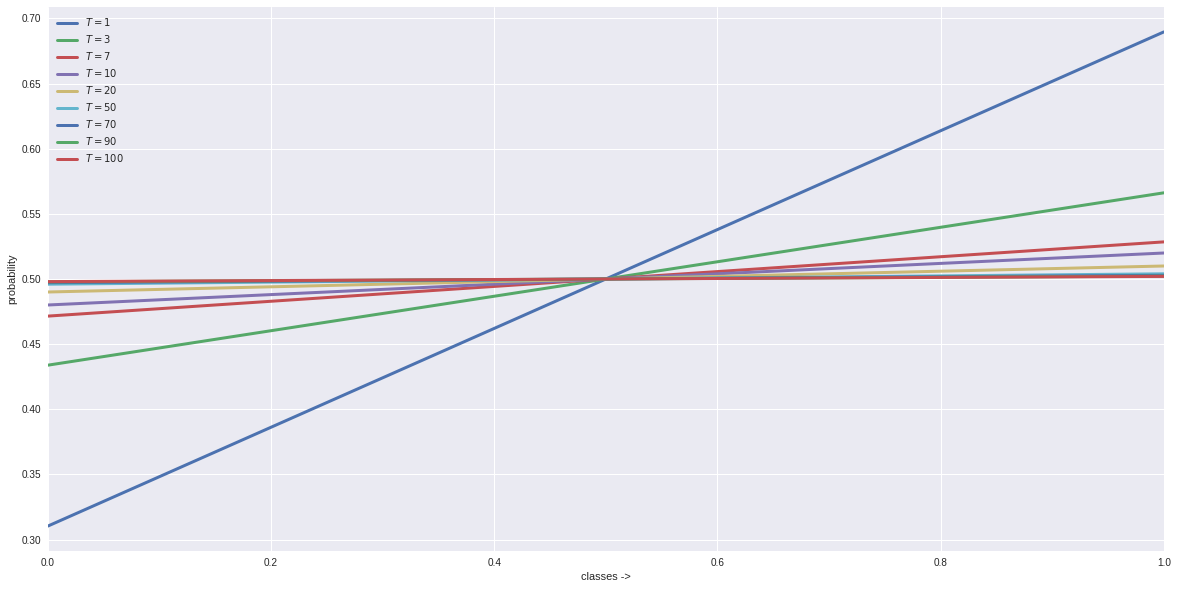

In [ ]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(x_train[122].reshape(1,224,224,3))
print(softmax(intermediate_output))
print('\n')

pixels = x_train[122]
pixels = pixels.reshape((224, 224, 3))
plt.imshow(pixels)
plt.show()
print('\n')

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize = (20, 10));

temperature = [1,3,7,10,20,50,70,90,100]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=3);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 1]);
plt.show()

In [ ]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
modelvgg16.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = modelvgg16.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model as mobileNet
modelvgg16 = Model(modelvgg16.input, output)

modelvgg16.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
module_wrapper_4_input (InputLa [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
module_wrapper_4 (ModuleWrapper (None, 7, 7, 512)    14714688    module_wrapper_4_input[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 512)          0           module_wrapper_4[0][0]           
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 512)          0           global_average_pooling2d_4[0][0] 
____________________________________________________________________________________________

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function
nb_classes = 2
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

modelvgg16.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] 
  )

In [ ]:
# Train the student model with MobileNet
epochs = 20
batch_size = 64
student_his_vgg16 = modelvgg16.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 119s 1s/step - loss: 0.0811 - acc: 0.3983 - val_loss: 0.0669 - val_acc: 0.5850
Epoch 2/20
88/88 [==============================] - 80s 914ms/step - loss: 0.0680 - acc: 0.5764 - val_loss: 0.0545 - val_acc: 0.8107
Epoch 3/20
88/88 [==============================] - 81s 918ms/step - loss: 0.0594 - acc: 0.7031 - val_loss: 0.0489 - val_acc: 0.8836
Epoch 4/20
88/88 [==============================] - 81s 917ms/step - loss: 0.0535 - acc: 0.7823 - val_loss: 0.0454 - val_acc: 0.9107
Epoch 5/20
88/88 [==============================] - 81s 916ms/step - loss: 0.0485 - acc: 0.8438 - val_loss: 0.0433 - val_acc: 0.9243
Epoch 6/20
88/88 [==============================] - 80s 913ms/step - loss: 0.0478 - acc: 0.8527 - val_loss: 0.0419 - val_acc: 0.9329
Epoch 7/20
88/88 [==============================] - 80s 913ms/step - loss: 0.0458 - acc: 0.8757 - val_loss: 0.0411 - val_acc: 0.9336
Epoch 8/20
88/88 [==============================] - 80s 914ms/step - lo

In [ ]:
Y_val_pred = modelvgg16.predict(x_val)
print(f'The VGG16 Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The VGG16 Accuracy on the Validation Set: 0.9464285714285714


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = modelvgg16.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.27074355 0.72925645 0.47524893 0.52475107]
 [0.27560607 0.72439396 0.4758597  0.52414024]
 [0.27177322 0.72822684 0.4753788  0.5246212 ]
 ...
 [0.2742775  0.7257225  0.4756935  0.52430654]
 [0.714255   0.28574505 0.52288747 0.47711253]
 [0.26934612 0.7306539  0.47507212 0.5249279 ]]

Time:  20.499023653999757 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Student model with VGG16 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Student model with VGG16 on the Test set is: 0.9983333333333333


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

----

**InceptionV3**

In [ ]:
from tensorflow.keras.applications import InceptionV3

def inceptionV3_model(backbone , lr = 1e-4):
  modelInceptionV3 = Sequential()
  modelInceptionV3.add(backbone)
  modelInceptionV3.add(layers.GlobalAveragePooling2D())
  modelInceptionV3.add(layers.Dropout(0.5))
  modelInceptionV3.add(layers.BatchNormalization())
  modelInceptionV3.add(layers.Dense(2 , activation='softmax'))
  
  modelInceptionV3.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return modelInceptionV3


inceptionV3 = InceptionV3(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
# call the model 
modelInceptionV3 = inceptionV3_model(inceptionV3 , lr = 1e-4)
modelInceptionV3.build((None, 224, 224, 3))
modelInceptionV3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_5 (ModuleWrap (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 21,815,074
Trainable params: 21,776,546
Non-trainable params: 38,528
_________________________________________________________________


----

In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense_1').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

[[0.3103464  0.68965364]]




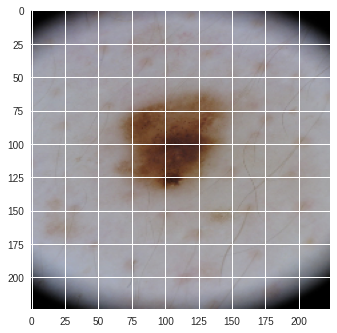

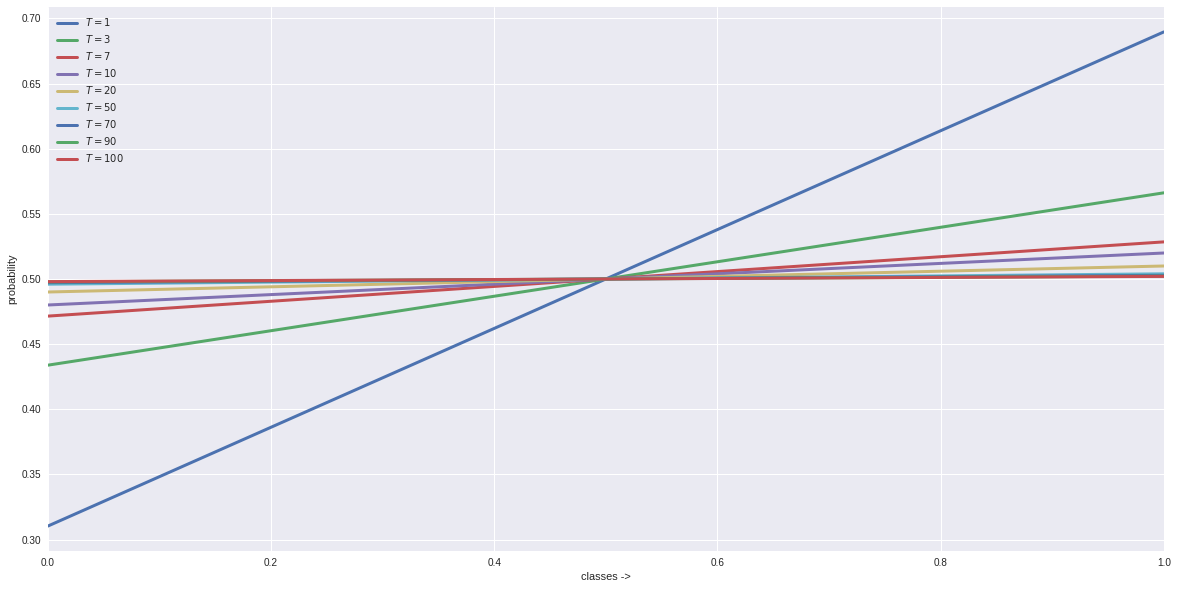

In [ ]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(x_train[122].reshape(1,224,224,3))
print(softmax(intermediate_output))
print('\n')

pixels = x_train[122]
pixels = pixels.reshape((224, 224, 3))
plt.imshow(pixels)
plt.show()
print('\n')

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize = (20, 10));

temperature = [1,3,7,10,20,50,70,90,100]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=3);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 1]);
plt.show()

In [ ]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
modelInceptionV3.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = modelInceptionV3.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model as mobileNet
modelInceptionV3 = Model(modelInceptionV3.input, output)

modelInceptionV3.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
module_wrapper_5_input (InputLa [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
module_wrapper_5 (ModuleWrapper (None, 5, 5, 2048)   21802784    module_wrapper_5_input[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 2048)         0           module_wrapper_5[0][0]           
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           global_average_pooling2d_5[0][0] 
____________________________________________________________________________________________

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function
nb_classes = 2
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

modelInceptionV3.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] 
  )

In [ ]:
# Train the student model with MobileNet
epochs = 20
batch_size = 64
student_his_inceptionV3 = modelInceptionV3.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 61s 563ms/step - loss: 0.0730 - acc: 0.5201 - val_loss: 0.0743 - val_acc: 0.4664
Epoch 2/20
88/88 [==============================] - 44s 499ms/step - loss: 0.0707 - acc: 0.5465 - val_loss: 0.0666 - val_acc: 0.5957
Epoch 3/20
88/88 [==============================] - 44s 496ms/step - loss: 0.0673 - acc: 0.5990 - val_loss: 0.0619 - val_acc: 0.6921
Epoch 4/20
88/88 [==============================] - 44s 496ms/step - loss: 0.0644 - acc: 0.6298 - val_loss: 0.0588 - val_acc: 0.7379
Epoch 5/20
88/88 [==============================] - 44s 496ms/step - loss: 0.0626 - acc: 0.6624 - val_loss: 0.0562 - val_acc: 0.7779
Epoch 6/20
88/88 [==============================] - 44s 497ms/step - loss: 0.0607 - acc: 0.6828 - val_loss: 0.0539 - val_acc: 0.8193
Epoch 7/20
88/88 [==============================] - 44s 498ms/step - loss: 0.0578 - acc: 0.7225 - val_loss: 0.0521 - val_acc: 0.8429
Epoch 8/20
88/88 [==============================] - 44s 496ms/step - 

In [ ]:
Y_val_pred = modelInceptionV3.predict(x_val)
print(f'The InceptionV3 model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The InceptionV3 model Accuracy on the Validation Set: 0.92


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = modelInceptionV3.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.3387152  0.6612848  0.48328063 0.5167194 ]
 [0.28453362 0.7154664  0.47696424 0.52303576]
 [0.27340883 0.7265911  0.47558454 0.52441543]
 ...
 [0.28063798 0.71936196 0.47648486 0.5235151 ]
 [0.72313374 0.2768663  0.52398306 0.47601694]
 [0.30909947 0.6909005  0.47990254 0.5200975 ]]

Time:  10.260213121000561 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Student model with InceptionV3 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Student model with InceptionV3 on the Test set is: 0.985


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1500
           1       0.98      0.99      0.99      1500

    accuracy                           0.98      3000
   macro avg       0.99      0.99      0.98      3000
weighted avg       0.99      0.98      0.98      3000



In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**END**